### Importing Dependencies

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler #(standardize data to common range)
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

### 1. Data Collection And Preprocessing

#### PIMA Diabetes Dataset

In [ ]:
 # Loading the diabetes dataset to pandas dataframe
df=pd.read_csv("/content/NIDDK_Pima.csv")

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# statistical measure of data
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [ ]:
# pd.read_csv?

In [ ]:
df.shape

(768, 9)

## Missing Observation Analysis

We saw on df.head() that some features contain 0, it doesn't make sense here and this indicates missing value Below we replace 0 value by NaN:

In [ ]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [ ]:
# Now, we can look at where are missing values
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [ ]:
# The missing values ​​will be filled with the median values ​​of each variable.
def median_target(var):
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [ ]:
# The values to be given for incomplete observations are given the median value of people who are not sick and the median values of people who are sick.
columns = df.columns
columns = columns.drop("Outcome")
for i in columns:
    median_target(i)
    df.loc[(df['Outcome'] == 0 ) & (df[i].isnull()), i] = median_target(i)[i][0]
    df.loc[(df['Outcome'] == 1 ) & (df[i].isnull()), i] = median_target(i)[i][1]

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [ ]:
# Missing values were filled.
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Outlier Observation Analysis

In [ ]:
# In the data set, there were asked whether there were any outlier observations compared to the 25% and 75% quarters.
# It was found to be an outlier observation.
for feature in df:

    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1- 1.5*IQR
    upper = Q3 + 1.5*IQR

    if df[(df[feature] > upper)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

Pregnancies yes
Glucose no
BloodPressure yes
SkinThickness yes
Insulin yes
BMI yes
DiabetesPedigreeFunction yes
Age yes
Outcome no


In [ ]:
#We conduct a stand alone observation review for the Insulin variable
#We suppress contradictory values
Q1 = df.Insulin.quantile(0.25)
Q3 = df.Insulin.quantile(0.75)
IQR = Q3-Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
df.loc[df["Insulin"] > upper,"Insulin"] = upper

## Local Outlier Factor (LOF)

In [ ]:
# We determine outliers between all variables with the LOF method
from sklearn.neighbors import LocalOutlierFactor
lof =LocalOutlierFactor(n_neighbors= 10)
lof.fit_predict(df)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1

In [ ]:
df_scores = lof.negative_outlier_factor_
np.sort(df_scores)[0:30]

array([-3.05893469, -2.37289269, -2.15297995, -2.09708735, -2.0772561 ,
       -1.95255968, -1.86384019, -1.74003158, -1.72703492, -1.71674689,
       -1.70343883, -1.6688722 , -1.64296768, -1.64190437, -1.61620872,
       -1.61369917, -1.60057603, -1.5988774 , -1.59608032, -1.57027568,
       -1.55876022, -1.55674614, -1.51852389, -1.50843907, -1.50280943,
       -1.50160698, -1.48391514, -1.4752983 , -1.4713427 , -1.47006248])

In [ ]:
#We choose the threshold value according to lof scores
threshold = np.sort(df_scores)[7]
threshold

-1.740031580305444

In [ ]:
#We delete those that are higher than the threshold
outlier = df_scores > threshold
df = df[outlier]

In [ ]:
# The size of the data set was examined.
df.shape

(760, 9)

Labels <br>
   0 --> Non-Diabetic <br>
   1 --> Diabetic

In [ ]:
#df.groupby("Outcome").mean()

In [ ]:
# this info is very important for us
# you can see person having more glucose level,insulin,age is diabetic

In [ ]:
# all data except labels
X= df.drop(columns="Outcome",axis=1)
y=df["Outcome"]

In [ ]:
print(X)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0           72.0           35.0    169.5  33.6   
1              1     85.0           66.0           29.0    102.5  26.6   
2              8    183.0           64.0           32.0    169.5  23.3   
3              1     89.0           66.0           23.0     94.0  28.1   
4              0    137.0           40.0           35.0    168.0  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10    101.0           76.0           48.0    180.0  32.9   
764            2    122.0           70.0           27.0    102.5  36.8   
765            5    121.0           72.0           23.0    112.0  26.2   
766            1    126.0           60.0           32.0    169.5  30.1   
767            1     93.0           70.0           31.0    102.5  30.4   

     DiabetesPedigreeFunction  Age  
0                       0.627   50  
1                       0.351   31  


In [ ]:
print(y)

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 760, dtype: int64


#### Data Standardization

In [ ]:
# for better prediction we will standardize them
# scaler=StandardScaler()

In [ ]:
# scaler.fit(X)

In [ ]:
# standardized_data = scaler.transform(X)

In [ ]:
# print(standardized_data)

In [ ]:
# X=standardized_data
# y=df["Outcome"]

In [ ]:
# print(X)
# print(y)

### 2.Train Test Split

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y, random_state=2)

In [ ]:
# stratify on "Outcome" column to maintain similar proportion of diabetic or non-diabetic
# random-state is like an index number for partiular splitting of data

In [ ]:
print(X.shape,X_train.shape,X_test.shape)

(760, 8) (608, 8) (152, 8)


### 3. Model Training

#### SVM Classifier

Training

In [ ]:
classifier=svm.SVC(kernel='linear')

In [ ]:
classifier.fit(X_train,y_train)

SVC(kernel='linear')

In [ ]:
# accuracy_score of training data

X_train_prediction=classifier.predict(X_train)
training_data_accuracy_score=accuracy_score(y_train,X_train_prediction)
print(f"Accuracy Score of training data : {training_data_accuracy_score * 100} %")

Accuracy Score of training data : 83.38815789473685 %


In [ ]:
# accuracy_score of testing data

X_test_prediction=classifier.predict(X_test)
testing_data_accuracy_score=accuracy_score(y_test,X_test_prediction)
print(f"Accuracy Score of testing data : {testing_data_accuracy_score * 100} %")

Accuracy Score of testing data : 82.89473684210526 %


#### Evaluation of Model

Random Forest

In [ ]:
classifier_rf = RandomForestClassifier(random_state=123)

In [ ]:
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [ ]:
y_test_pred_rf = classifier_rf.predict(X_test)
testing_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Accuracy Score on testing data: {testing_accuracy_rf * 100:.2f}%")

Accuracy Score on testing data: 86.18%


#### Evaluation of Model

Training

KNN

Training

In [ ]:
classifier_knn = KNeighborsClassifier()

In [ ]:
classifier_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_train_pred_knn = classifier_knn.predict(X_train)
training_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
print(f"Accuracy Score on training data: {training_accuracy_knn * 100:.2f}%")

Accuracy Score on training data: 89.14%


In [ ]:
y_test_pred_knn = classifier_knn.predict(X_test)
testing_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print(f"Accuracy Score on testing data: {testing_accuracy_knn * 100:.2f}%")

Accuracy Score on testing data: 87.50%


#### Evaluation of Model

XGBOOST

In [ ]:
classifier_xgb = xgb.XGBClassifier()

In [ ]:
classifier_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Evaluation of Model

In [ ]:
y_test_pred_xgb = classifier_xgb.predict(X_test)
testing_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
print(f"Accuracy Score on testing data: {testing_accuracy_xgb * 100:.2f}%")

Accuracy Score on testing data: 88.82%


Training

### Saving the Trained Model

In [ ]:
import pickle

In [ ]:
filename="diabetesmodel.sav"
pickle.dump(classifier_xgb,open(filename,'wb'))

In [ ]:
# loading the saved model
loaded_model=pickle.load(open("diabetesmodel.sav",'rb'))

### Making a Predictive System

In [ ]:
# 1,85,66,29,0,26.6,0.351,31,0
# 8,183,64,0,0,23.3,0.672,32,1
#input_data=(2,110,70,25,80,25,0.3,30)

input_data=(3,150,70,30,90,25.5,0.45,35)
# change input_data to numpy array
inp_data_as_numpy_arr=np.asarray(input_data)
print(f"1D Data : {inp_data_as_numpy_arr}\n")

# input data reshape because model is expecting 2D array or all data , we'll reshape our 1d data to 2d and feed our model an instance
inp_data_reshape=inp_data_as_numpy_arr.reshape(1,-1)
print(f"2D Data : {inp_data_reshape}\n")

# standardize the input data
# std_data=scaler.transform(inp_data_reshape)
# print(f"Standardized Data : {std_data}\n")

# prediction
prediction = loaded_model.predict(inp_data_reshape)
print(f"Predicted Value: {prediction}")
if(prediction[0]==0):
    print("This person is Non-Diabetic")
else:
    print("This person is Diabetic")

1D Data : [  3.   150.    70.    30.    90.    25.5    0.45  35.  ]

2D Data : [[  3.   150.    70.    30.    90.    25.5    0.45  35.  ]]

Predicted Value: [1]
This person is Diabetic


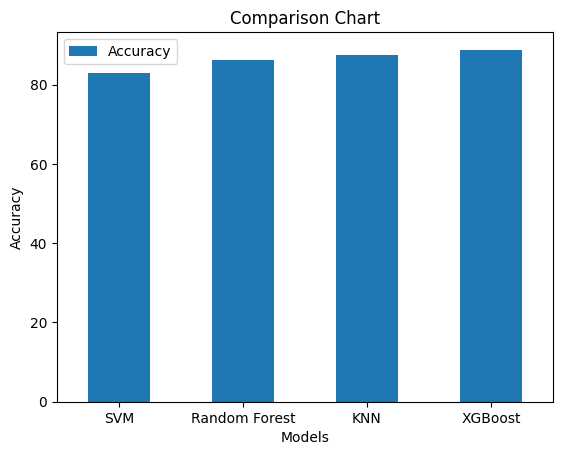

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
data = {
    'Category': ['SVM', 'Random Forest', 'KNN', 'XGBoost'],
    'Accuracy': [82.89, 86.18, 87.5, 88.82]
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Set the index to 'Category'
df.set_index('Category', inplace=True)

# Plot the data
df.plot(kind='bar')
plt.title('Comparison Chart')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.show()

In [ ]:
#svm classifier
classifier=svm.SVC(kernel='linear')
classifier.fit(X_train,y_train)
X_train_prediction=classifier.predict(X_train)
training_data_accuracy_score=accuracy_score(y_train,X_train_prediction)
print(f"Accuracy Score of training data : {training_data_accuracy_score * 100} %")
X_test_prediction=classifier.predict(X_test)
testing_data_accuracy_score=accuracy_score(y_test,X_test_prediction)
print(f"Accuracy Score of testing data : {testing_data_accuracy_score * 100} %")

#Random Forest
classifier_rf = RandomForestClassifier(random_state=123)
classifier_rf.fit(X_train, y_train)
y_test_pred_rf = classifier_rf.predict(X_test)
testing_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Accuracy Score on testing data: {testing_accuracy_rf * 100:.2f}%")

#KNN
classifier_knn = KNeighborsClassifier()
classifier_knn.fit(X_train, y_train)
y_train_pred_knn = classifier_knn.predict(X_train)
training_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
print(f"Accuracy Score on training data: {training_accuracy_knn * 100:.2f}%")
y_test_pred_knn = classifier_knn.predict(X_test)
testing_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print(f"Accuracy Score on testing data: {testing_accuracy_knn * 100:.2f}%")

#XGBoost
classifier_xgb = xgb.XGBClassifier()
classifier_xgb.fit(X_train, y_train)
y_test_pred_xgb = classifier_xgb.predict(X_test)
testing_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
print(f"Accuracy Score on testing data: {testing_accuracy_xgb * 100:.2f}%")